# Taller 3

In [17]:
import pandas as pd
pd.set_option('display.max_columns', 500)

df = pd.read_csv('taller_3_small.csv')

In [31]:
df.head(10)

,Periodo,Ventas_IT,Otros_Ingresos_IT,Costos_Fijos_IT,Costos_Variables_IT,Capacidad_Pago_Ajustada_IT,Capacidad_Pago_IT,Resultado_Operacional_IT,Deudas_IT,sexo,edad,est_civil,comuna,region,act_eco_cod,act_eco_des,sec_cod,DDVI,DM,DDVE,DDC,DDVI1,DM1,DDVE1,DDC1,DDVI2,DM2,DDVE2,DDC2,DDVI3,DM3,DDVE3,DDC3,DDVI4,DM4,DDVE4,DDC4,DDVI5,DM5,DDVE5,DDC5,DDVI6,DM6,DDVE6,DDC6,VFM_M6,dda_max,Vector_FM_Max,Vector_FM_Min,MPMA,MPMR,DPMA,DPMR,NPB30,MPB30,NPE3090,MPE3090,NPS90,MPS90,NA6M,MA6M,pro_sin_acl,inf_lab,Tipo_Cliente,dop_sdo_cst,Nuevo_Antiguo_Prod,Comportamiento_SBFI,Comportamiento_BEME,Perfil_Riesgo,mora_6m,var_deu,Score_Amb_SMRT01,Ptje_Amb_SMRT01,Cant_Op_12M_SICA,Ptje_SICA,PERFIL,COD_OFI,OFICINA,REGION_OFICINA,MODULO,ZONA_OFICINA,TIPO_CLIENTE,CHEQ,Protestos_Sin_Aclarar,Infracciones_Laborales,COD_EJC_ACTUAL,Medidas_Restrictivas,CHEQ_SIN_CV,CHEQ_CV,CTA_CTE,FONDOS_MUTUOS,AHORRO,TCDN,TCDI,FRECUENCIA_INGRESO,CLIENTE_FORMAL,COD_EJECUTIVO,COMUNA_EXPERIAN,CANT_COMPRAS_MENSUALES,FORMALIDAD,MONTO_PROM_COMPRA,OTRAS_DEUDAS,OTROS_GASTOS_ME,TOTAL_ACT_CIRC,TOTAL_ACT_FIJO,SUB_SEGMENTO,MICRO_SEGMENTO,SCP_MSL_COD_SUC,SCP_MSL_TIP_CRD_SOL,SCP_MSL_TIP_MDU,SCP_MTT_TIT_COM,SCP_MTT_TIT_EDA,SCP_MTT_TIT_EST_CIV,SCP_MTT_TIT_NAC,SCP_MTT_TIT_RGM_CYG,SCP_MTT_TIT_RGN,SCP_MTT_TIT_SEX,SCP_MTT_TIT_TSC_CMR,SCP_MTT_FEC_NCT_CLI,SCP_MIC_PFL_PMA_NEG,SCP_MIC_FOR,SCP_MIC_NNS,SCP_MIC_SGM,SCP_MIC_SSG,SCP_MIC_MCS,SCP_MIC_DEU_PRO_VIV,SCP_MIC_CNE_INA,SCP_MIC_FEC_INA,SCP_MIC_ATE,SCP_MCE_FEC_ULT_CRD,SCP_MCE_LCR_DIS,SCP_MPD_MNT_SOL,SCP_MBU_SBS_HBT_ASG,SCP_MIC_GRP_FAM_ADL,SCP_MIC_GRP_FAM_NNO,SCP_MIC_GST_FAM_SME,SCP_MIC_OTR_GST_VIV,SCP_MIC_PRD_COS_MOB,SCP_MIC_PRD_COS_MPM
0,201601,1078167,85000,38500,600000,191800,319667,439667,0,0.0,83.0,0.0,50.0,5.0,0.0,S/I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no deudor,0.0,NUEVO,BUENO,BUENO,BUENO,0.0,1.0,0.078022,921.97797,0.0,934.268799,MI,331.0,Stgo. Independencia,13.0,Metrop. Norte,Zona Metropolitana,deudor comercial,X,0.0,0.0,6062.0,NO,31.0,0.0,0.0,0.0,82531.0,0.0,0.0,M,0,6817,81,4,SF,150000,0,0,550000,30200000,106,1943,331,101,5,81,80,4,1,9,13,M,1,1935-12-29,600,SF,9088,MMIC,106,1943,6,0,9999-12-31,686,2006-05-23,0,1200000,0,2,1,200000,0,0.0,1.000000e+33
1,201601,1917765,190000,79332,1446666,277060,461767,391767,0,0.0,78.0,3.0,NaN,0.0,62111.0,"Botillerías: Depósitos de vinos, licores y beb...",3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no deudor,0.0,NUEVO,BUENO,BUENO,BUENO,0.0,1.0,0.078022,921.97797,0.0,934.268799,MI,357.0,Stgo. El Bosque,13.0,Metrop. Sur,Zona Metropolitana,deudor comercial,X,0.0,0.0,6318.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,M,1,6698,100,8,FO,175000,0,0,4000000,56000000,106,7021,357,101,6,100,76,4,1,9,13,F,1,1939-12-29,240,FO,9023,MMIC,106,7021,6,1,1996-05-29,544,2013-09-25,0,3000000,0,1,0,120000,0,0.0,1.000000e+38
2,201601,2650972,107927,385000,1423333,271055,451759,842639,0,2.0,75.0,1.0,80.0,13.0,62522.0,Artículos típicos (artesanía),3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NUEVO,BUENO,BUENO,BUENO,0.0,1.0,0.078022,921.97797,NaN,NaN,MI,57.0,Santiago Santa Lucia,13.0,Metrop. Centro,Zona Metropolitana,deudor comercial,NaN,0.0,0.0,6179.0,NO,0.0,0.0,0.0,0.0,301775.0,0.0,0.0,M,1,7365,80,4,FO,350000,0,0,10800000,40200000,106,7021,57,100,21,80,74,2,1,1,13,M,1,1941-01-27,264,FO,9025,PERSO,106,7021,6,1,1993-01-01,544,9999-12-31,0,1000000,0,2,0,300000,0,0.0,1.400000e+38
3,201601,3926041,0,578000,2100000,638155,638155,1248041,0,1.0,75.0,2.0,70.0,5.0,62412.0,Prendas de vestir (excepto calzado),3.0,2278.0,0.0,0.0,0.0,2556.0,0.0,0.0,0.0,2613.0,0.0,0.0,0.0,2850.0,0.0,0.0,0.0,3060.0,0.0,0.0,0.0,3220.0,0.0,0.0

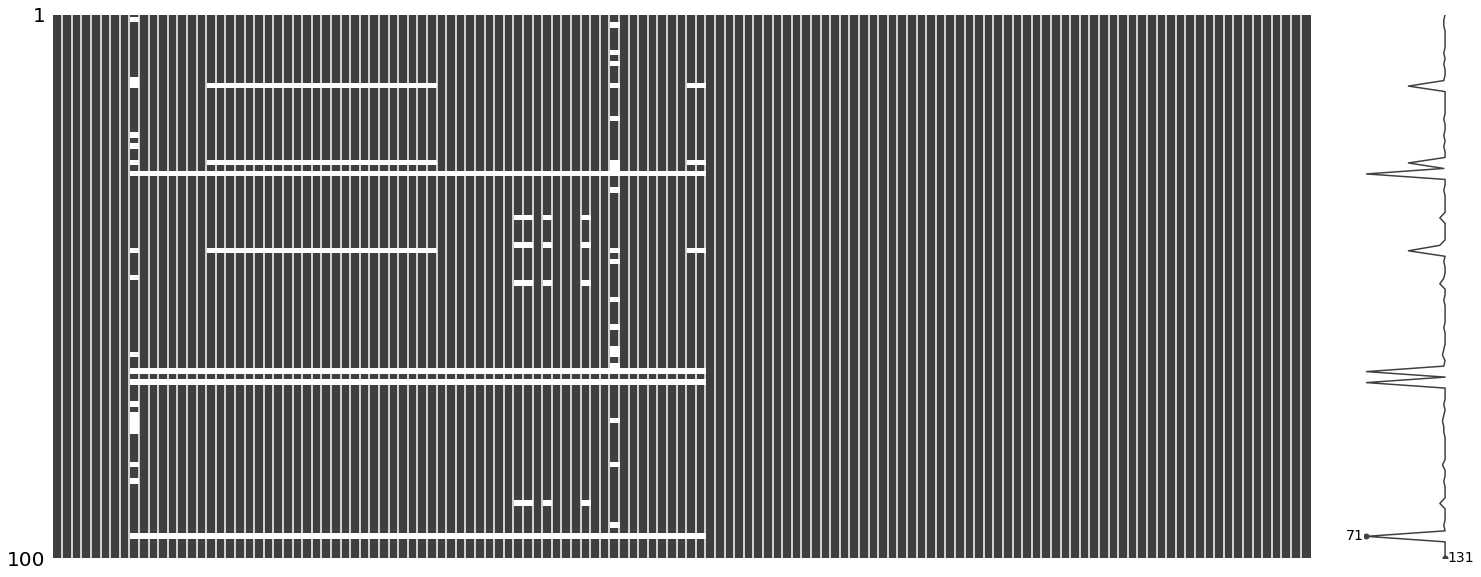

In [48]:
%matplotlib inline
import missingno as msno

msno.matrix(df[:100])

In [68]:
# drop (almost) empty columns
for col in ['Id', 'COD_EJEC_ORIGEN', 'DEP_PLAZO', 'CUADRANTE', 'CHEQ']:
    if col in df.columns:
        del df[col]
        
# drop personal information
for col in ['sexo', 'edad', 'est_civil']:
    if col in df.columns:
        del df[col]
        
# drop useless or duplicate or difficult information
for col in ['Periodo', 'act_eco_des', 'Cant_Op_12M_SICA', 'Ptje_SICA', 'OFICINA', 'ZONA_OFICINA', 'TIPO_CLIENTE']:
    if col in df.columns:
        del df[col]

# pesos in accounts, replace NaN (account does not exist) with zero (pesos)
df.fillna({'CHEQ_SIN_CV':0, 'CHEQ_CV':0, 'CTA_CTE':0, 'FONDOS_MUTUOS':0, 'AHORRO':0, 'TCDN':0, 'TCDI':0}, inplace=True)

df.fillna({'comuna':0}, inplace=True)

In [75]:
df2 = df.copy()

for col in ['Tipo_Cliente', 'Nuevo_Antiguo_Prod', 'Comportamiento_SBFI', 'Comportamiento_BEME',
            'Perfil_Riesgo', 'PERFIL', 'MODULO', 'FRECUENCIA_INGRESO', 'FORMALIDAD', 'SCP_MTT_TIT_SEX',
            'SCP_MIC_FOR', 'SCP_MIC_SGM', 'Medidas_Restrictivas']:
    encoded = pd.get_dummies(df2[col], prefix=col, dummy_na=True)
    df2 = pd.concat([df2, encoded], axis=1).drop(col, axis=1)
    
df2

,Ventas_IT,Otros_Ingresos_IT,Costos_Fijos_IT,Costos_Variables_IT,Capacidad_Pago_Ajustada_IT,Capacidad_Pago_IT,Resultado_Operacional_IT,Deudas_IT,comuna,region,act_eco_cod,sec_cod,DDVI,DM,DDVE,DDC,DDVI1,DM1,DDVE1,DDC1,DDVI2,DM2,DDVE2,DDC2,DDVI3,DM3,DDVE3,DDC3,DDVI4,DM4,DDVE4,DDC4,DDVI5,DM5,DDVE5,DDC5,DDVI6,DM6,DDVE6,DDC6,VFM_M6,dda_max,Vector_FM_Max,Vector_FM_Min,MPMA,MPMR,DPMA,DPMR,NPB30,MPB30,NPE3090,MPE3090,NPS90,MPS90,NA6M,MA6M,pro_sin_acl,inf_lab,dop_sdo_cst,mora_6m,var_deu,Score_Amb_SMRT01,Ptje_Amb_SMRT01,COD_OFI,REGION_OFICINA,Protestos_Sin_Aclarar,Infracciones_Laborales,COD_EJC_ACTUAL,CHEQ_SIN_CV,CHEQ_CV,CTA_CTE,FONDOS_MUTUOS,AHORRO,TCDN,TCDI,CLIENTE_FORMAL,COD_EJECUTIVO,COMUNA_EXPERIAN,CANT_COMPRAS_MENSUALES,MONTO_PROM_COMPRA,OTRAS_DEUDAS,OTROS_GASTOS_ME,TOTAL_ACT_CIRC,TOTAL_ACT_FIJO,SUB_SEGMENTO,MICRO_SEGMENTO,SCP_MSL_COD_SUC,SCP_MSL_TIP_CRD_SOL,SCP_MSL_TIP_MDU,SCP_MTT_TIT_COM,SCP_MTT_TIT_EDA,SCP_MTT_TIT_EST_CIV,SCP_MTT_TIT_NAC,SCP_MTT_TIT_RGM_CYG,SCP_MTT_TIT_RGN,SCP_MTT_TIT_TSC_CMR,SCP_MTT_FEC_NCT_CLI,SCP_MIC_PFL_PMA_NEG,SCP_MIC_NNS,SCP_MIC_SSG,SCP_MIC_MCS,SCP_MIC_DEU_PRO_VIV,SCP_MIC_CNE_INA,SCP_MIC_FEC_INA,SCP_MIC_ATE,SCP_MCE_FEC_ULT_CRD,SCP_MCE_LCR_DIS,SCP_MPD_MNT_SOL,SCP_MBU_SBS_HBT_ASG,SCP_MIC_GRP_FAM_ADL,SCP_MIC_GRP_FAM_NNO,SCP_MIC_GST_FAM_SME,SCP_MIC_OTR_GST_VIV,SCP_MIC_PRD_COS_MOB,SCP_MIC_PRD_COS_MPM,Tipo_Cliente_castigado,Tipo_Cliente_deudor comercial,Tipo_Cliente_deudor no comercial,Tipo_Cliente_no deudor,Tipo_Cliente_sin producto,Tipo_Cliente_nan,Nuevo_Antiguo_Prod_ANTIGUO,Nuevo_Antiguo_Prod_NUEVO,Nuevo_Antiguo_Prod_nan,Comportamiento_SBFI_BUENO,Comportamiento_SBFI_EXCELENTE,Comportamiento_SBFI_MALO,Comportamiento_SBFI_REGULAR,Comportamiento_SBFI_nan,Comportamiento_BEME_BUENO,Comportamiento_BEME_EXCELENTE,Comportamiento_BEME_MALO,Comportamiento_BEME_REGULAR,Comportamiento_BEME_nan,Perfil_Riesgo_BUENO,Perfil_Riesgo_EXCELENTE,Perfil_Riesgo_MALO,Perfil_Riesgo_REGULAR,Perfil_Riesgo_nan,PERFIL_MI,PERFIL_nan,MODULO_Gestión Centralizada,MODULO_I Región,MODULO_II Región,MODULO_III Región,MODULO_IV Región,MODULO_IX Región Norte,MODULO_IX Región Sur,MODULO_Metrop. Centro,MODULO_Metrop. Norte,MODULO_Metrop. Oriente,MODULO_Metrop. Poniente,MODULO_Metrop. Sur,MODULO_V Región Cordillera,MODULO_V Región Costa,MODULO_VI Región,MODULO_VII Región,MODULO_VIII Región Cordillera,MODULO_VIII Región Costa,MODULO_X Región de los Lagos,MODULO_XI Región,MODULO_XII Región,MODULO_XIV Región de los Ríos,MODULO_nan,FRECUENCIA_INGRESO_A,FRECUENCIA_INGRESO_B,FRECUENCIA_INGRESO_M,FRECUENCIA_INGRESO_S,FRECUENCIA_INGRESO_T,FRECUENCIA_INGRESO_nan,FORMALIDAD_FO,FORMALIDAD_IN,FORMALIDAD_SF,FORMALIDAD_nan,SCP_MTT_TIT_SEX_F,SCP_MTT_TIT_SEX_M,SCP_MTT_TIT_SEX_nan,SCP_MIC_FOR_FO,SCP_MIC_FOR_IN,SCP_MIC_FOR_SF,SCP_MIC_FOR_nan,SCP_MIC_SGM_ECONC,SCP_MIC_SGM_ECONT,SCP_MIC_SGM_ISFL,SCP_MIC_SGM_MMIC,SCP_MIC_SGM_MMICA,SCP_MIC_SGM_MMSIN,SCP_MIC_SGM_MPEQ,SCP_MIC_SGM_MSOM,SCP_MIC_SGM_PERSO,SCP_MIC_SGM_SINSE,SCP_MIC_SGM_SNCLA,SCP_MIC_SGM_nan,Medidas_Restrictivas_NO,Medidas_Restrictivas_SI,Medidas_Restrictivas_nan
0,1078167,85000,38500,600000,191800,319667,439667,0,50.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.078022,921.97797,331.0,13.0,0.0,0.0,6062.0,31.0,0.0,0.0,0.0,82531.0,0.0,0.0,0,6817,81,4,150000,0,0,550000,30200000,106,1943,331,101,5,81,80,4,1,9,13,1,1935-12-29,600,9088,106,1943,6,0,9999-12-31,686,2006-05-23,0,1200000,0,2,1,200000,0,0.0,1.000000e+33,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,1917765,190000,79332,1446666,277060,461767,391767,0,0.0,0.0,62111.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.078022,921.97

In [76]:
df3 = df2.copy()

for col in ['SCP_MTT_FEC_NCT_CLI', 'SCP_MIC_FEC_INA', 'SCP_MCE_FEC_ULT_CRD']:
    df3.loc[df3[col] == '9999-12-31',col] = '1900-01-01'
    df3[col] = pd.to_datetime(df3[col])
    df3[col] = (df3[col]-pd.to_datetime('1900-01-01')).dt.total_seconds()

df3

,Ventas_IT,Otros_Ingresos_IT,Costos_Fijos_IT,Costos_Variables_IT,Capacidad_Pago_Ajustada_IT,Capacidad_Pago_IT,Resultado_Operacional_IT,Deudas_IT,comuna,region,act_eco_cod,sec_cod,DDVI,DM,DDVE,DDC,DDVI1,DM1,DDVE1,DDC1,DDVI2,DM2,DDVE2,DDC2,DDVI3,DM3,DDVE3,DDC3,DDVI4,DM4,DDVE4,DDC4,DDVI5,DM5,DDVE5,DDC5,DDVI6,DM6,DDVE6,DDC6,VFM_M6,dda_max,Vector_FM_Max,Vector_FM_Min,MPMA,MPMR,DPMA,DPMR,NPB30,MPB30,NPE3090,MPE3090,NPS90,MPS90,NA6M,MA6M,pro_sin_acl,inf_lab,dop_sdo_cst,mora_6m,var_deu,Score_Amb_SMRT01,Ptje_Amb_SMRT01,COD_OFI,REGION_OFICINA,Protestos_Sin_Aclarar,Infracciones_Laborales,COD_EJC_ACTUAL,CHEQ_SIN_CV,CHEQ_CV,CTA_CTE,FONDOS_MUTUOS,AHORRO,TCDN,TCDI,CLIENTE_FORMAL,COD_EJECUTIVO,COMUNA_EXPERIAN,CANT_COMPRAS_MENSUALES,MONTO_PROM_COMPRA,OTRAS_DEUDAS,OTROS_GASTOS_ME,TOTAL_ACT_CIRC,TOTAL_ACT_FIJO,SUB_SEGMENTO,MICRO_SEGMENTO,SCP_MSL_COD_SUC,SCP_MSL_TIP_CRD_SOL,SCP_MSL_TIP_MDU,SCP_MTT_TIT_COM,SCP_MTT_TIT_EDA,SCP_MTT_TIT_EST_CIV,SCP_MTT_TIT_NAC,SCP_MTT_TIT_RGM_CYG,SCP_MTT_TIT_RGN,SCP_MTT_TIT_TSC_CMR,SCP_MTT_FEC_NCT_CLI,SCP_MIC_PFL_PMA_NEG,SCP_MIC_NNS,SCP_MIC_SSG,SCP_MIC_MCS,SCP_MIC_DEU_PRO_VIV,SCP_MIC_CNE_INA,SCP_MIC_FEC_INA,SCP_MIC_ATE,SCP_MCE_FEC_ULT_CRD,SCP_MCE_LCR_DIS,SCP_MPD_MNT_SOL,SCP_MBU_SBS_HBT_ASG,SCP_MIC_GRP_FAM_ADL,SCP_MIC_GRP_FAM_NNO,SCP_MIC_GST_FAM_SME,SCP_MIC_OTR_GST_VIV,SCP_MIC_PRD_COS_MOB,SCP_MIC_PRD_COS_MPM,Tipo_Cliente_castigado,Tipo_Cliente_deudor comercial,Tipo_Cliente_deudor no comercial,Tipo_Cliente_no deudor,Tipo_Cliente_sin producto,Tipo_Cliente_nan,Nuevo_Antiguo_Prod_ANTIGUO,Nuevo_Antiguo_Prod_NUEVO,Nuevo_Antiguo_Prod_nan,Comportamiento_SBFI_BUENO,Comportamiento_SBFI_EXCELENTE,Comportamiento_SBFI_MALO,Comportamiento_SBFI_REGULAR,Comportamiento_SBFI_nan,Comportamiento_BEME_BUENO,Comportamiento_BEME_EXCELENTE,Comportamiento_BEME_MALO,Comportamiento_BEME_REGULAR,Comportamiento_BEME_nan,Perfil_Riesgo_BUENO,Perfil_Riesgo_EXCELENTE,Perfil_Riesgo_MALO,Perfil_Riesgo_REGULAR,Perfil_Riesgo_nan,PERFIL_MI,PERFIL_nan,MODULO_Gestión Centralizada,MODULO_I Región,MODULO_II Región,MODULO_III Región,MODULO_IV Región,MODULO_IX Región Norte,MODULO_IX Región Sur,MODULO_Metrop. Centro,MODULO_Metrop. Norte,MODULO_Metrop. Oriente,MODULO_Metrop. Poniente,MODULO_Metrop. Sur,MODULO_V Región Cordillera,MODULO_V Región Costa,MODULO_VI Región,MODULO_VII Región,MODULO_VIII Región Cordillera,MODULO_VIII Región Costa,MODULO_X Región de los Lagos,MODULO_XI Región,MODULO_XII Región,MODULO_XIV Región de los Ríos,MODULO_nan,FRECUENCIA_INGRESO_A,FRECUENCIA_INGRESO_B,FRECUENCIA_INGRESO_M,FRECUENCIA_INGRESO_S,FRECUENCIA_INGRESO_T,FRECUENCIA_INGRESO_nan,FORMALIDAD_FO,FORMALIDAD_IN,FORMALIDAD_SF,FORMALIDAD_nan,SCP_MTT_TIT_SEX_F,SCP_MTT_TIT_SEX_M,SCP_MTT_TIT_SEX_nan,SCP_MIC_FOR_FO,SCP_MIC_FOR_IN,SCP_MIC_FOR_SF,SCP_MIC_FOR_nan,SCP_MIC_SGM_ECONC,SCP_MIC_SGM_ECONT,SCP_MIC_SGM_ISFL,SCP_MIC_SGM_MMIC,SCP_MIC_SGM_MMICA,SCP_MIC_SGM_MMSIN,SCP_MIC_SGM_MPEQ,SCP_MIC_SGM_MSOM,SCP_MIC_SGM_PERSO,SCP_MIC_SGM_SINSE,SCP_MIC_SGM_SNCLA,SCP_MIC_SGM_nan,Medidas_Restrictivas_NO,Medidas_Restrictivas_SI,Medidas_Restrictivas_nan
0,1078167,85000,38500,600000,191800,319667,439667,0,50.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.078022,921.97797,331.0,13.0,0.0,0.0,6062.0,31.0,0.0,0.0,0.0,82531.0,0.0,0.0,0,6817,81,4,150000,0,0,550000,30200000,106,1943,331,101,5,81,80,4,1,9,13,1,1.135728e+09,600,9088,106,1943,6,0,0.000000e+00,686,3.357331e+09,0,1200000,0,2,1,200000,0,0.0,1.000000e+33,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,1917765,190000,79332,1446666,277060,461767,391767,0,0.0,0.0,62111.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.078022,

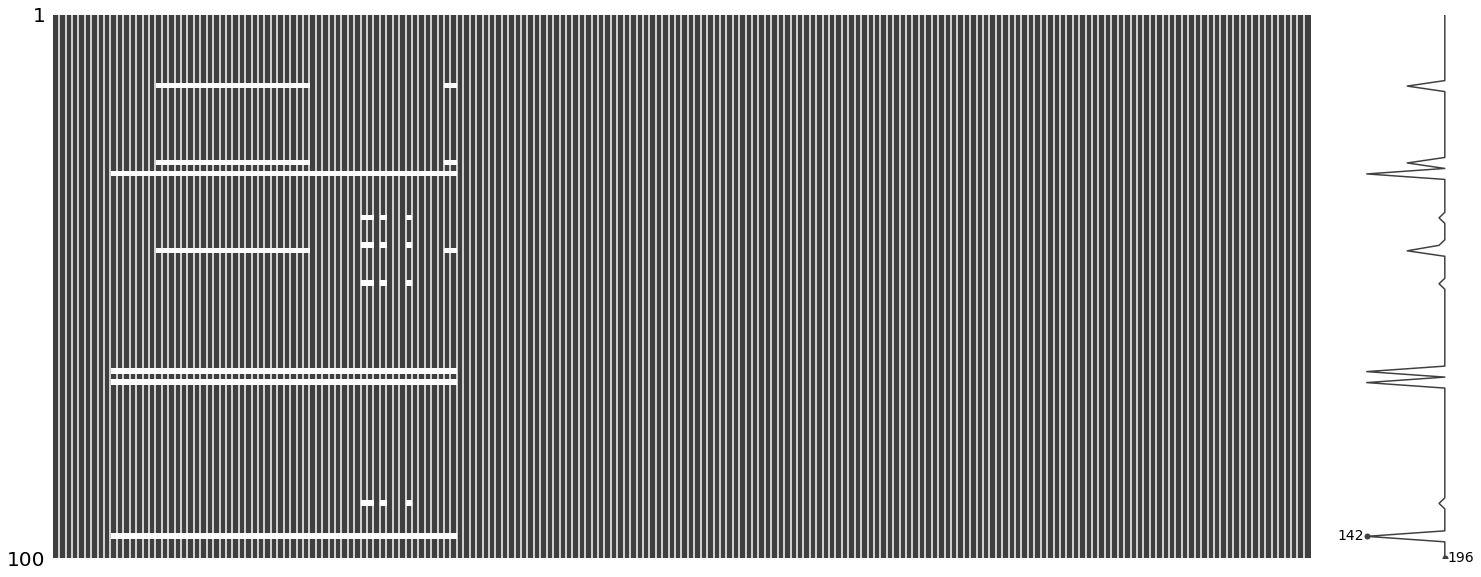

In [77]:
%matplotlib inline
import missingno as msno

msno.matrix(df3[:100])

In [78]:
df4 = df3.copy()
df4 = df4.dropna()
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12362 entries, 0 to 19999
Columns: 196 entries, Ventas_IT to Medidas_Restrictivas_nan
dtypes: float64(72), int64(43), uint8(81)
memory usage: 11.9 MB


In [84]:
df5 = df4.copy()

features = list(set(list(df4.columns))-set(['Ventas_IT','Otros_Ingresos_IT','Costos_Fijos_IT','Costos_Variables_IT','Capacidad_Pago_Ajustada_IT','Capacidad_Pago_IT','Resultado_Operacional_IT','Deudas_IT']))
for col in features:
    if df5[col].max()-df5[col].min() == 0:
        del df5[col]
        features = list(set(features)-set([col]))
        
df5[features] = (df5[features]-df5[features].min())/(df5[features].max()-df5[features].min())

df5

,Ventas_IT,Otros_Ingresos_IT,Costos_Fijos_IT,Costos_Variables_IT,Capacidad_Pago_Ajustada_IT,Capacidad_Pago_IT,Resultado_Operacional_IT,Deudas_IT,comuna,region,act_eco_cod,sec_cod,DDVI,DM,DDVE,DDC,DDVI1,DM1,DDVE1,DDC1,DDVI2,DM2,DDVE2,DDC2,DDVI3,DM3,DDVE3,DDC3,DDVI4,DM4,DDVE4,DDC4,DDVI5,DM5,DDVE5,DDC5,DDVI6,DM6,DDVE6,DDC6,VFM_M6,dda_max,Vector_FM_Max,Vector_FM_Min,MPMA,MPMR,DPMA,DPMR,NPB30,MPB30,NPE3090,MPE3090,NPS90,MPS90,NA6M,MA6M,pro_sin_acl,inf_lab,mora_6m,var_deu,Score_Amb_SMRT01,Ptje_Amb_SMRT01,COD_OFI,REGION_OFICINA,Protestos_Sin_Aclarar,Infracciones_Laborales,COD_EJC_ACTUAL,CHEQ_SIN_CV,CHEQ_CV,CTA_CTE,FONDOS_MUTUOS,AHORRO,TCDN,TCDI,CLIENTE_FORMAL,COD_EJECUTIVO,COMUNA_EXPERIAN,CANT_COMPRAS_MENSUALES,MONTO_PROM_COMPRA,OTRAS_DEUDAS,OTROS_GASTOS_ME,TOTAL_ACT_CIRC,TOTAL_ACT_FIJO,SUB_SEGMENTO,MICRO_SEGMENTO,SCP_MSL_COD_SUC,SCP_MSL_TIP_CRD_SOL,SCP_MSL_TIP_MDU,SCP_MTT_TIT_COM,SCP_MTT_TIT_EDA,SCP_MTT_TIT_EST_CIV,SCP_MTT_TIT_NAC,SCP_MTT_TIT_RGM_CYG,SCP_MTT_TIT_RGN,SCP_MTT_TIT_TSC_CMR,SCP_MTT_FEC_NCT_CLI,SCP_MIC_PFL_PMA_NEG,SCP_MIC_NNS,SCP_MIC_MCS,SCP_MIC_DEU_PRO_VIV,SCP_MIC_CNE_INA,SCP_MIC_FEC_INA,SCP_MIC_ATE,SCP_MCE_FEC_ULT_CRD,SCP_MCE_LCR_DIS,SCP_MPD_MNT_SOL,SCP_MBU_SBS_HBT_ASG,SCP_MIC_GRP_FAM_ADL,SCP_MIC_GRP_FAM_NNO,SCP_MIC_GST_FAM_SME,SCP_MIC_OTR_GST_VIV,SCP_MIC_PRD_COS_MOB,SCP_MIC_PRD_COS_MPM,Tipo_Cliente_castigado,Tipo_Cliente_deudor comercial,Tipo_Cliente_deudor no comercial,Tipo_Cliente_no deudor,Tipo_Cliente_sin producto,Tipo_Cliente_nan,Nuevo_Antiguo_Prod_ANTIGUO,Nuevo_Antiguo_Prod_NUEVO,Comportamiento_SBFI_BUENO,Comportamiento_SBFI_EXCELENTE,Comportamiento_SBFI_MALO,Comportamiento_SBFI_REGULAR,Comportamiento_BEME_BUENO,Comportamiento_BEME_EXCELENTE,Comportamiento_BEME_MALO,Comportamiento_BEME_REGULAR,Perfil_Riesgo_BUENO,Perfil_Riesgo_EXCELENTE,Perfil_Riesgo_MALO,Perfil_Riesgo_REGULAR,MODULO_I Región,MODULO_II Región,MODULO_III Región,MODULO_IV Región,MODULO_IX Región Norte,MODULO_IX Región Sur,MODULO_Metrop. Centro,MODULO_Metrop. Norte,MODULO_Metrop. Oriente,MODULO_Metrop. Poniente,MODULO_Metrop. Sur,MODULO_V Región Cordillera,MODULO_V Región Costa,MODULO_VI Región,MODULO_VII Región,MODULO_VIII Región Cordillera,MODULO_VIII Región Costa,MODULO_X Región de los Lagos,MODULO_XI Región,MODULO_XII Región,MODULO_XIV Región de los Ríos,FRECUENCIA_INGRESO_A,FRECUENCIA_INGRESO_B,FRECUENCIA_INGRESO_M,FRECUENCIA_INGRESO_S,FRECUENCIA_INGRESO_T,FORMALIDAD_FO,FORMALIDAD_IN,FORMALIDAD_SF,SCP_MTT_TIT_SEX_F,SCP_MTT_TIT_SEX_M,SCP_MTT_TIT_SEX_nan,SCP_MIC_FOR_FO,SCP_MIC_FOR_IN,SCP_MIC_FOR_SF,SCP_MIC_SGM_ECONT,SCP_MIC_SGM_ISFL,SCP_MIC_SGM_MMIC,SCP_MIC_SGM_MMICA,SCP_MIC_SGM_MPEQ,SCP_MIC_SGM_MSOM,SCP_MIC_SGM_PERSO,SCP_MIC_SGM_SNCLA,SCP_MIC_SGM_nan,Medidas_Restrictivas_NO,Medidas_Restrictivas_SI
0,1078167,85000,38500,600000,191800,319667,439667,0,0.144092,0.384615,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056509,0.943491,0.358696,0.857143,0.0,0.0,0.017641,0.000001,0.000000,0.000559,0.000000e+00,0.001099,0.036103,0.0,0.0,0.765525,0.233429,0.031250,0.003604,0.000000,0.0,0.001022,0.027455,0.757143,0.250613,0.358696,9.609337e-07,0.130435,0.233429,0.952381,0.500,0.166667,1.0,0.866667,0.0,0.311729,0.138889,0.260377,0.001180,0.833333,0.0,0.000000,0.901445,0.907600,0.000000,0.0048,0.0,0.0250,0.05,0.0800,0.000000,0.000000e+00,1.574803e-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1917765,190000,79332,1446666,277060,461767,391767,0,0.000000,0.000000,0.647050,0.3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.00,0.00

## Test and train set

In [129]:
from sklearn.model_selection import train_test_split
import torch

targets = df5.columns[~df5.columns.isin(features)]

X = df5[features].values
y = df5[targets].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_valid = torch.from_numpy(X_valid).float()

In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

class Net(nn.Module):
    def __init__(self, n_in, n_out):
        super(Net, self).__init__()
        print("Input dimension:", n_in)
        print("Output dimension:", n_out)
        self.fc1 = nn.Linear(n_in, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, n_out)        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
modelo = Net(len(features), len(targets))
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.001)
criterion = nn.MSELoss()

dataset = utils.TensorDataset(X_train, y_train)
trainloader = utils.DataLoader(dataset, batch_size=500)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        xs, ys = data
        
        modelo.zero_grad()

        outputs = modelo(xs)
        
        loss = criterion(outputs, ys)
        loss.backward()        
        optimizer.step()
        
        running_loss += loss.item()
    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss))

print('Finished Training')

Input dimension: 171
Output dimension: 8
[1,    18] loss: 894372523016192.000
[2,    18] loss: 894362961051648.000
[3,    18] loss: 894314937843712.000
[4,    18] loss: 894171123548160.000
[5,    18] loss: 893850262962176.000
[6,    18] loss: 893258193960960.000
[7,    18] loss: 892298420813824.000
[8,    18] loss: 890883118465024.000
[9,    18] loss: 888943314206720.000
[10,    18] loss: 886438159187968.000
Finished Training


In [143]:
import numpy as np
predictions = modelo(X_valid).detach().numpy()
# Calculate the absolute errors
errors = abs(predictions - y_valid)

# Print out the mean absolute error (mae)
print('Mean Absolute Error (test):', round(np.mean(errors), 2), 'degrees.')


predictions = modelo(X_train).detach().numpy()
# Calculate the absolute errors
errors = abs(predictions - y_train.detach().numpy())

# Print out the mean absolute error (mae)
print('Mean Absolute Error (train):', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error (test): 1425332.5 degrees.
Mean Absolute Error (train): 1261482.5 degrees.


In [138]:
def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_valid, predictions), 2), '%.')

MAPE: 16709.5 %.
